# Introduction to Machine Learning: Classification

We demonstrate the models we discussed within the context of a common financial services problem - **predicting loan default.**  This is an important part of the loan approval process within financial institutions like retail banks.  Approving a customer who is not credit-worthy can result in large financial losses for the bank. Machine Learning has contributed to improvements in credit approval/loan application processes.

The dataset was obtained from Kaggle, and was originally provided as a relational database. This means information related to specific aspects of the data are stored in different tables - for example, current loan applications are stored separate to previous loan applications. Each table is joined by a key. Please see the site for more details.
https://www.kaggle.com/c/home-credit-default-risk

The various tables originally provided in Kaggle have been meared, and also has been sub-sampled to (significantly) reduced the sample we look at today.  We only consider "cash loans".  This is so code will finish running in our tutorial.  Please feel free to look at all the available data, and try to build your own modelling dataset.

## Loading ML packages

The core ML package used in R is `caret`.  Check out the documentation:

https://topepo.github.io/caret/

In [2]:
library(caret) # ML package
library(randomForest)
library(e1071)
library(rpart.plot)
library(mltools)
library(xgboost)

library(dplyr) # packages for working with data frames/data tables
library(data.table)
library(zoo) # functions for consistent data type handling

library(ggplot2) # visualisation package

## Loading the data

In [3]:
application_data <- read.csv("./data/loan_risk.csv")
nrow(application_data)

[1] 5000

In [4]:
summary(application_data)

       X          SK_ID_CURR         TARGET    CODE_GENDER       
 Min.   :   1   Min.   :100085   Min.   :0.0   Length:5000       
 1st Qu.:1251   1st Qu.:189918   1st Qu.:0.0   Class :character  
 Median :2500   Median :281664   Median :0.0   Mode  :character  
 Mean   :2500   Mean   :279564   Mean   :0.3                     
 3rd Qu.:3750   3rd Qu.:368502   3rd Qu.:1.0                     
 Max.   :5000   Max.   :456253   Max.   :1.0                     
                                                                 
 FLAG_OWN_CAR       FLAG_OWN_REALTY     CNT_CHILDREN    AMT_INCOME_TOTAL 
 Length:5000        Length:5000        Min.   :0.0000   Min.   :  27000  
 Class :character   Class :character   1st Qu.:0.0000   1st Qu.: 112500  
 Mode  :character   Mode  :character   Median :0.0000   Median : 157500  
                                       Mean   :0.4386   Mean   : 168485  
                                       3rd Qu.:1.0000   3rd Qu.: 202500  
                            

In [5]:
modelling_feature_list <- colnames(application_data[,-(1:3)])
modelling_feature_list

[1] "CODE_GENDER"                "FLAG_OWN_CAR"              
 [3] "FLAG_OWN_REALTY"            "CNT_CHILDREN"              
 [5] "AMT_INCOME_TOTAL"           "AMT_CREDIT"                
 [7] "AMT_ANNUITY"                "AMT_GOODS_PRICE"           
 [9] "NAME_TYPE_SUITE"            "NAME_INCOME_TYPE"          
[11] "NAME_EDUCATION_TYPE"        "NAME_FAMILY_STATUS"        
[13] "NAME_HOUSING_TYPE"          "REGION_POPULATION_RELATIVE"
[15] "DAYS_BIRTH"                 "DAYS_EMPLOYED"             
[17] "OCCUPATION_TYPE"            "CNT_FAM_MEMBERS"           
[19] "INCOME_CREDIT_PERC"         "INCOME_PER_PERSON"         
[21] "ANNUITY_INCOME_PERC"        "PAYMENT_RATE"              
[23] "ACTIVE_LOAN"                "DAYS_CREDIT"               
[25] "CREDIT_DAY_OVERDUE"         "AMT_CREDIT_SUM"            
[27] "DAYS_CREDIT_UPDATE"         "CREDIT_ACTIVE"             
[29] "ACTIVE_CREDIT"              "NUMBER_PREV_LOANS"         
[31] "DIFFERENT_LOAN_PRODUCTS"    "PREV_AMT_RECEIVED_MEAN"    
[33] "PREV_AMT_APPLICATION"       "PREV_AMT_ANNUITY"          
[35] "PREV_AMT_CREDIT"            "AMT_DOWN_PAYMENT"          
[37] "PREV_DAYS_DECISION"         "PREV_CNT_PAYMENT"          
[39] "PREV_RATE_DOWN_PAYMENT"     "INCOME_TO_TOTAL_ANNUITY"

## Train and Test splits of data

We first split our data into a train and test set.  The training set is what we use to fit our models, and the test set is put aside for model evaluation/benchmarking at the end.

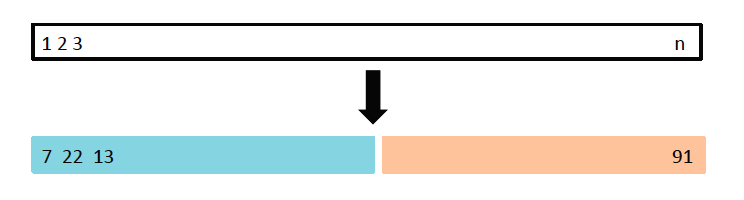

In [6]:
set.seed(123)
trainIndex <- createDataPartition(application_data$TARGET, p = .7, 
                                  list = FALSE, 
                                  times = 1)
                                  
train_data <- application_data[ trainIndex,]
test_data  <- application_data[-trainIndex,]

In [7]:
summary(train_data[["TARGET"]])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.2946  1.0000  1.0000 

## Training CART

To train our tree, we use 5-fold cross-validation to select the training parameters.

In [9]:
X_train <- train_data %>% select(all_of(modelling_feature_list))
y_train <- as.factor(ifelse(train_data[["TARGET"]]==1,"Default","Healthy"))
X_test <- test_data %>% select(modelling_feature_list)
y_test <- as.factor(ifelse(test_data[["TARGET"]]==1,"Default","Healthy"))
  
train_data_cart <- cbind(y_train,X_train)
test_data_cart <- cbind(y_test,X_test)
  
fit_control <- trainControl(
    method = "cv",
    number = 5,
    savePredictions = TRUE,
    classProbs = TRUE
)

### Set up grid for grid search

In a grid search, we set up a "grid" which represents combinations of different parameters.  

We then fit models on each combination, and assess which combination provided the best fit based on a specified metric.

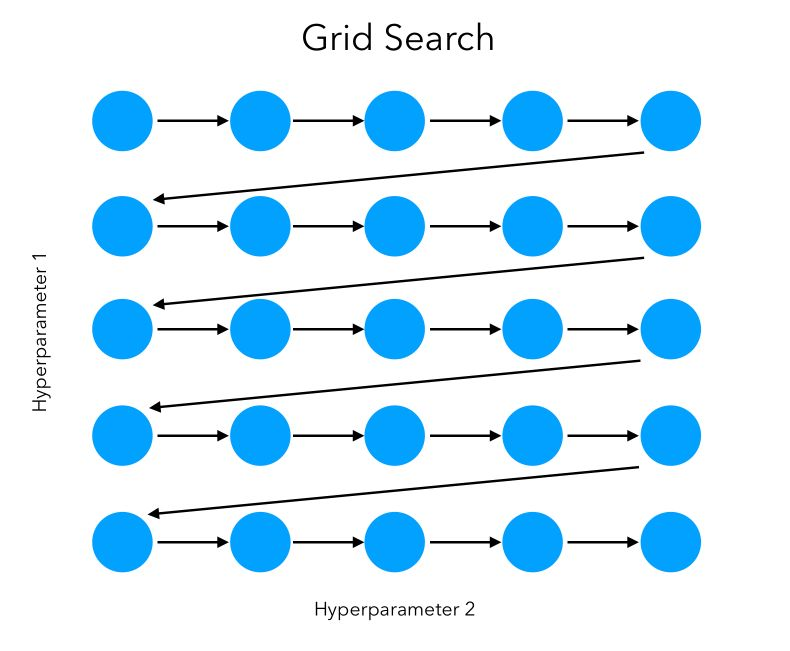

The fitting process is repeated on each different "folds"/sets of our training data, so that we can compare performance without touching our test set.  For example, say we are performing 5-fold CV - this means we create 5 sets of our training data, which each comprises 20% of the sample.  5 models are trained on a 80-20 split, with each of the 5 folds taking in turn to be the set of data we use to assess model performance.

In [10]:
grid <- expand.grid(
    cp=c(0.01,0.02,0.03,0.04,0.05,0.1)
    )
    
grid

cp
<dbl>
0.01
0.02
0.03
0.04
0.05
0.10


### Train CART model

In [11]:
cart_fit <- caret::train(
    y_train ~ .
    ,data = train_data_cart
    ,method = "rpart"
    ,trControl = fit_control
    ,tuneGrid = grid
    ,na.action = na.pass
    ,weights = ifelse(train_data_cart$y_train == "Default",
                        (1/sum(train_data_cart$y_train=="Default") * 0.5),
                        (1/sum(train_data_cart$y_train=="Healthy") * 0.5))
  )
   
# Make predictions on the test data
cart_predictions_train <- predict(cart_fit, newdata=X_train, type="prob", na.action = na.pass)[,"Default"]

cart_predictions_test <- predict(cart_fit, newdata=X_test, type="prob", na.action = na.pass)[,"Default"]

cart_fit

CART 

3500 samples
  40 predictor
   2 classes: 'Default', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2800, 2801, 2800, 2800, 2799 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa     
  0.01  0.5808515  0.13032312
  0.02  0.5639874  0.10912861
  0.03  0.5499874  0.10084348
  0.04  0.5499874  0.10084348
  0.05  0.5582604  0.08900317
  0.10  0.5216890  0.07364118

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

### CART plot

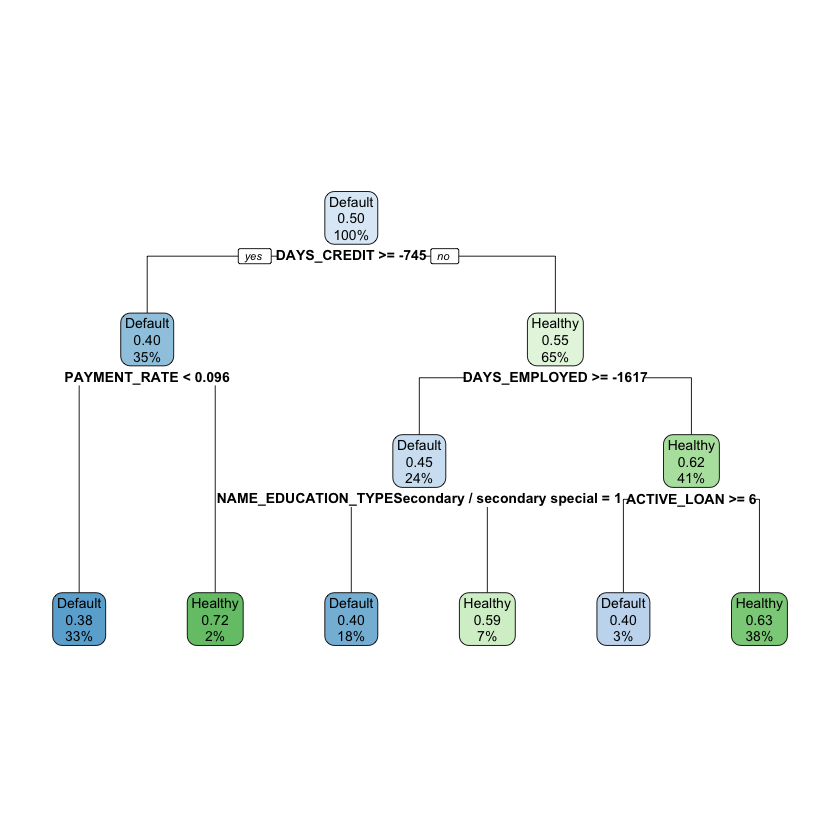

In [12]:
rpart.plot(cart_fit$finalModel)

### Confusion Matrix for CART model

We now use confusion matrices to evaluate our Classification Tree model.  Recall, the confusion matrix which shows us the True Positive, True Negatives, False Positives and False Negatives, gives us a view of how accurate our model is and how it does in the 2 types of error (False Positives - Type I and False Negatives - Type II).

The confusion matrix is also dependent on the decision criterion we use to translate the predicted probabilities into categorical outcomes.

In [13]:
decision_criterion_Conf_Matrix <- function(
    predictions
    ,true_labels
    ,decision_criterion) {
    predictions_threshold <- as.factor(ifelse(predictions<decision_criterion,0,1))
    confusionMatrix(predictions_threshold,true_labels)
}

decision_criterion_Conf_Matrix(
    predictions=cart_predictions_test
    ,true_labels=as.factor(test_data[["TARGET"]])
    ,decision_criterion=0.5)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 607 173
         1 424 296
                                          
               Accuracy : 0.602           
                 95% CI : (0.5767, 0.6269)
    No Information Rate : 0.6873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1919          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.5887          
            Specificity : 0.6311          
         Pos Pred Value : 0.7782          
         Neg Pred Value : 0.4111          
             Prevalence : 0.6873          
         Detection Rate : 0.4047          
   Detection Prevalence : 0.5200          
      Balanced Accuracy : 0.6099          
                                          
       'Positive' Class : 0               
                              

## Training a Random Forest

Recall, a Random Forest model is an ensemble method with many trees trained simultaneously to target the high variance of a single classification tree.

A Random Forest introduces one key new parameter - the number of trees corresponding to the parameter name n_estimators.  The random forest also introduces training parameters related to sampling data e.g. max features to consider on each split.

We can now wrap all the steps we used in the CART model when training a Random Forest model, into a single pipeline.

The implementation of Random Forest we are using, is from the `randomForest` R package.  We vary the `mtry` parameter which controls the column sampling approach adopted by the method.  We set a limit of 200 trees, with a max number of terminal nodes of 10 (shallow trees).

In [ ]:
# And hence, we can train a Random Forest model in a single pipeline - in the future, you can just change your data specifications for your problem
my_rf <- train_random_forest(
  train_data=train_data
  ,test_data=test_data
  ,outcome_var=c("TARGET")
  ,features_for_model = modelling_feature_list
  ,number_cvs=5)

In [14]:
my_rf$model_obj

Random Forest 

3500 samples
  40 predictor
   2 classes: 'Default', 'Healthy' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2800, 2800, 2801, 2800, 2799 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa      
   2    0.7054287  0.000000000
   3    0.7054287  0.000000000
   4    0.7054287  0.000000000
   8    0.7054287  0.000000000
  12    0.7054287  0.000000000
  16    0.7054287  0.001585118
  20    0.7048577  0.002037114
  24    0.7059985  0.009013368
  28    0.7065700  0.011680824
  32    0.7068561  0.013006870

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 32.

## Training a Gradient Boosted Tree

A gradient boosted tree is also an ensemble method, which trains a series of weak learners where each new learner aims to correct the previous learners. 

In addition to the training parameters required for a Random Forest, the Gradient boosted tree uses learning_rate which varies how much the model tries to correct for previous misclassifications when estimating the next learner.  The learning rate by default is usually low.

In [15]:
train_xgb <- function(
  train_data
  ,test_data
  ,outcome_var
  ,target_cat="Default"
  ,other_cat="Healthy"
  ,features_for_model
  ,number_cvs=5) {
  
  X_train <- train_data %>% select(features_for_model)
  y_train <- as.factor(ifelse(train_data[["TARGET"]]==1,target_cat,other_cat))
  X_test <- test_data %>% select(features_for_model)
  y_test <- as.factor(ifelse(test_data[["TARGET"]]==1,target_cat,other_cat))  
  
  train_data_xgb <- cbind(y_train,X_train)
  test_data_xgb <- cbind(y_test,X_test)
  
  xgb_trcontrol <- trainControl(
    method = "cv"
    , number = number_cvs  
    , allowParallel = TRUE
    , verboseIter = FALSE
    , returnData = FALSE
    , classProbs = TRUE
  )
    
  xgbGrid <- expand.grid(
    nrounds = c(20,50,100)
    , max_depth = c(4,6,10)
    , colsample_bytree = seq(0.5,0.7)
    , eta = c(0.05,0.1)
    , gamma=c(0,0.05)
    , min_child_weight = c(4,6,10)
    , subsample = c(0.5,0.7,0.9)
  )      
    
    
  xgb_fit <- caret::train(
    y_train ~ .
    ,data = train_data_xgb
    ,method = "xgbTree"
    ,trControl = xgb_trcontrol
    ,tuneGrid = xgbGrid
    ,metric= "Accuracy"
    ,na.action = na.pass
    ,scale_pos_weight  = 5
  )

  xgb_predictions_train <- predict(xgb_fit, newdata=X_train, type="prob", na.action = na.pass)[,target_cat]
  
  xgb_predictions_test <- predict(xgb_fit, newdata=X_test, type="prob", na.action = na.pass)[,target_cat]
  
  return(list(
    model_obj = xgb_fit
    ,train_predicted_prob = xgb_predictions_train
    ,train_true_outcome = train_data[["TARGET"]]
    ,test_predicted_prob = xgb_predictions_test
    ,test_true_outcome = test_data[["TARGET"]]
  ))
}

In [16]:
my_gb <- train_xgb(
  train_data=train_data
  ,test_data=test_data
  ,outcome_var=c("TARGET")
  ,features_for_model = modelling_feature_list
  ,number_cvs=5)

In [17]:
my_gb$model_obj

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2800, 2800, 2800, 2800, 2800 
Resampling results across tuning parameters:

  eta   max_depth  gamma  min_child_weight  subsample  nrounds  Accuracy 
  0.05   4         0.00    4                0.5         20      0.4151429
  0.05   4         0.00    4                0.5         50      0.4694286
  0.05   4         0.00    4                0.5        100      0.5117143
  0.05   4         0.00    4                0.7         20      0.4074286
  0.05   4         0.00    4                0.7         50      0.4580000
  0.05   4         0.00    4                0.7        100      0.5162857
  0.05   4         0.00    4                0.9         20      0.3985714
  0.05   4         0.00    4                0.9         50      0.4522857
  0.05   4         0.00    4                0.9        100      0.5062857
  0.05   4         0.00    6                0.5         20      0.4077143
 

## Performance Evaluation

Some functions for quickly generating performance evaluation metrics are provided below.  These measures mostly rely on the confusion matrix, meaning they are also dpeendent on a specified decision criterion.  You can see how the performance of the model changes as you vary decision criterion thresholds.

In [18]:
simple_roc <- function(labels, scores){
    names(scores) <- 1:length(scores)
    names(labels) <- 1:length(labels)
    labels <- labels[order(scores, decreasing=TRUE)]
    data.frame(id=names(labels), TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels)
  }

calc_auc <- function(FPR, TPR) {
    sum(diff(FPR)*rollmean(TPR,2))
  }

# Provides performance summary for a given set of predictions and true outcomes, at a specified discriminant threshold value
return_performance_measures <- function(
  labels=test_na_omit
  , scores=xgb_predictions_test
  , threshold=0.5) {
  
  names(labels) <- 1:length(labels)
  names(scores) <- 1:length(scores)

  scores_threshed <- ifelse(scores>threshold,1,0)
  ordered_scores <- scores[order(scores, decreasing=TRUE)]
  ordered_labels <- labels[names(ordered_scores)]
  
  true_active <- sum(ordered_labels)
  true_inactive <- length(ordered_labels)-true_active
  
  all_performance_measures <- as.data.table(cbind(ordered_labels = as.integer(ordered_labels)
                                                  , ordered_scores = as.numeric(ordered_scores)))[,`:=`(
    ranking = rank(desc(ordered_scores))
  )][order(ranking),`:=`(
    TPR = cumsum(ordered_labels)
    ,FPR = cumsum(!ordered_labels)
  )][order(ranking),.(
    TPR = TPR/true_active
    ,FPR = FPR/true_inactive
  )]

  auc_measure_cutoff <- all_performance_measures[FPR<0.1][,.(
    auc_FPR.1_bound = calc_auc(FPR, TPR)*10
  )]
  
  auc <- calc_auc(all_performance_measures$FPR
                  , all_performance_measures$TPR)
  
  sensitivity <- sum(scores>=threshold & labels==1)/sum(labels==1)
  specificity <- sum(scores<threshold & labels==0)/sum(labels==0)
  precision <- sum(scores>=threshold & labels==1)/sum(scores>=threshold)
  
  balanced_accuracy <- (sensitivity + specificity)/2
  
  accuracy <- (sum(scores>=threshold & labels==1)+sum(scores<threshold & labels==0))/length(labels)
    
  return(cbind(
    decision_criterion = threshold
    ,accuracy = accuracy
    ,balanced_accuracy = balanced_accuracy
    ,sensitivity = sensitivity
    ,specificity = specificity
    ,precision = precision
    ,auc = auc
  ))           
}

### CART PERFORMANCE

In [19]:
binary_test_data <- test_data[["TARGET"]]
names(binary_test_data) <- 1:length(binary_test_data)

cart_perf <- return_performance_measures(
    labels=binary_test_data
  , scores=cart_predictions_test
  , threshold=0.5 # CHANGE HERECO
)

cart_perf

decision_criterion,accuracy,balanced_accuracy,sensitivity,specificity,precision,auc
0.5,0.602,0.6099394,0.6311301,0.5887488,0.4111111,0.6206862


### RF PERFORMANCE

In [20]:
rf_perf <- return_performance_measures(
    labels=my_rf$test_true_outcome
  , scores=my_rf$test_predicted_prob
  , threshold=0.3
)

rf_perf

decision_criterion,accuracy,balanced_accuracy,sensitivity,specificity,precision,auc
0.3,0.696,0.5318744,0.09381663,0.9699321,0.5866667,0.6596862


### GB PERFORMANCE

In [21]:
gb_perf <- return_performance_measures(
    labels=my_gb$test_true_outcome
  , scores=my_gb$test_predicted_prob
  , threshold=0.15
)

gb_perf

decision_criterion,accuracy,balanced_accuracy,sensitivity,specificity,precision,auc
0.15,0.4506667,0.574237,0.9040512,0.2444229,0.3524522,0.6685748


### Collated Summary

Now that we have multiple models, we can compare them on our test set.  Comparison on the test set allows us to benchmark our models on the same data.

Immediately, we can identify the trade-offs between different performance evaluation metrics.

In [22]:
collated_summary <- rbind(
    cbind(Model = "CART",cart_perf)
    ,cbind(Model = "Random Forest",rf_perf)
    ,cbind(Model = "Gradient Boosting",gb_perf)
)

collated_summary

Model,decision_criterion,accuracy,balanced_accuracy,sensitivity,specificity,precision,auc
CART,0.5,0.602,0.609939425775377,0.631130063965885,0.588748787584869,0.411111111111111,0.620686232134326
Random Forest,0.3,0.696,0.531874367941366,0.093816631130064,0.969932104752667,0.586666666666667,0.659686188704531
Gradient Boosting,0.15,0.450666666666667,0.574237031552781,0.904051172707889,0.244422890397672,0.352452202826268,0.668574820231667


### Comparing ROC Curves

Another performance evaluation metric is a ROC curve, which shows us the trade-off in the false positive rate for every correctly identified observation (represented in the true positive rate). 

The Area Under the Curve (AUC) can likewise be used to benchmark model performance, which is essentially just the area under the ROC curve.  An AUC of 1 is a perfect classifier so higher values of AUC demonstrate that the model is better over its competitors.

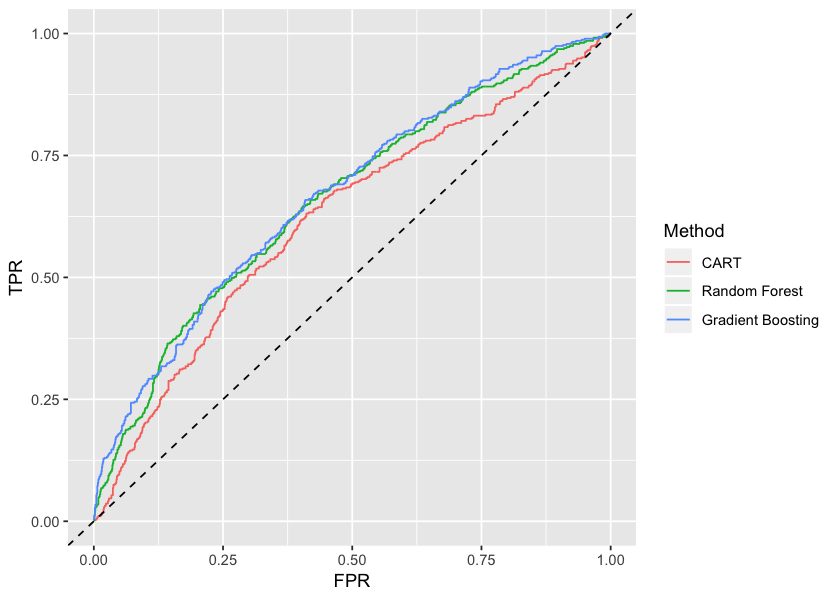

In [23]:
model_roc <- rbind(
    cbind(simple_roc(
    labels=test_data[["TARGET"]]
    ,scores=cart_predictions_test)
    ,Method="CART")
    ,cbind(simple_roc(
    labels=test_data[["TARGET"]]
    ,scores=my_rf$test_predicted_prob)
    ,Method="Random Forest")
    ,cbind(simple_roc(
    labels=test_data[["TARGET"]]
    ,scores=my_gb$test_predicted_prob)
    ,Method="Gradient Boosting")
)

options(repr.plot.width=7, repr.plot.height=5)

ggplot(model_roc,aes(
x=FPR, y=TPR, color=Method))+
geom_line()+
geom_abline(intercept = 0, slope = 1, linetype="dashed")

### Variable Importances

Variable importances provide us with information on which features are drivers/significant in prediction.

They quantify the mean decrease in impurity attributable to the feature over ensemble methods like Random Forests and Gradient boosted trees.

The feature with the highest variable importance contributed most to prediction!

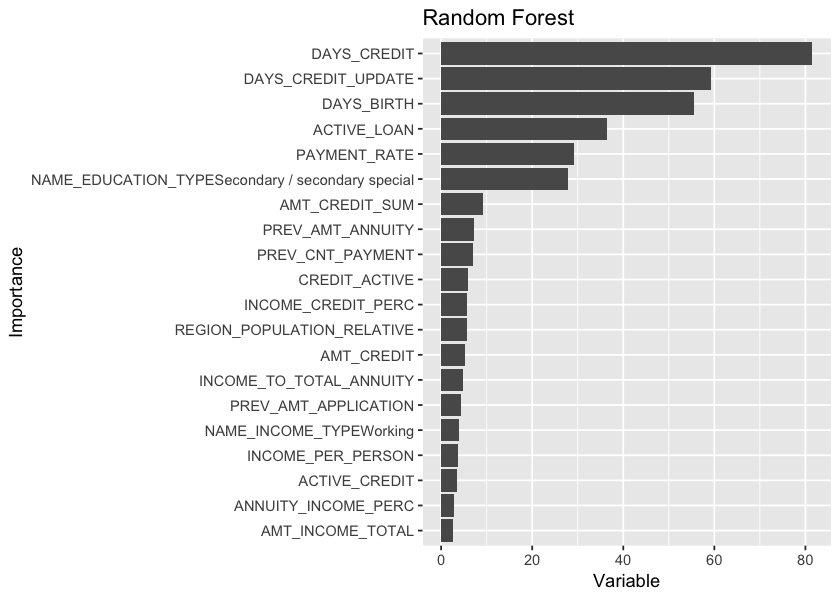

In [24]:
variable_importance_plots <- function(model
                                     ,model_name
                                     ,return_x) {
  variable_importance <- varImp(model, scale = TRUE)
  variable_importance_data <- as.data.table(cbind(var_names = rownames(variable_importance$importance)
                                                  ,importance = as.numeric(variable_importance$importance[[1]])))[,`:=`(
                                                    var_names = factor(var_names, levels = var_names[order(as.numeric(importance))]))]
  my_plot <- ggplot(variable_importance_data[order(importance, decreasing=TRUE)][1:return_x]
         ,aes(x=var_names
              ,y=as.numeric(importance)))+
    geom_bar(position="dodge",stat="identity") +
   labs(title=model_name)+
    ylab("Variable")+
    xlab("Importance")+
    coord_flip()
  print(my_plot)
}

variable_importance_plots(my_rf$model_obj
                         ,model_name="Random Forest"
                         ,return_x=20)

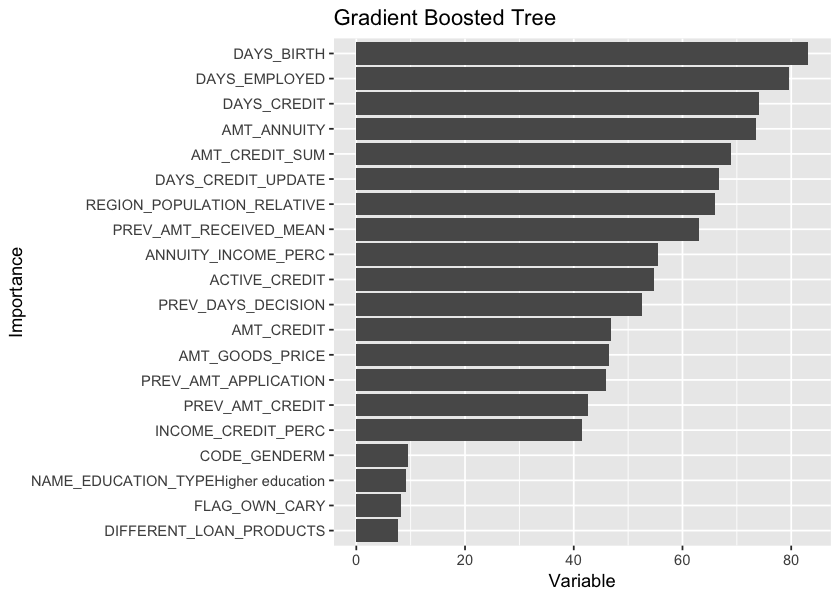

In [25]:
variable_importance_plots(my_gb$model_obj
                         ,model_name="Gradient Boosted Tree"
                         ,return_x=20)